$$
\newcommand{\Oframe}{\mathcal{O}}
\newcommand{\Bframe}{\mathcal{B}}
\newcommand{\R}{\mathbb{R}}
\newcommand{\Uset}{\mathcal{U}}
\newcommand{\Sset}{\mathbb{S}}
\newcommand{\braces}[1]{\left\{#1\right\}}
\newcommand{\parenth}[1]{\left(#1\right)}
\newcommand{\Rbot}{\mathcal{R}}
\newcommand{\Wspace}{\mathcal{W}}
\newcommand{\Wobs}{\mathcal{W}_{obs}}
\newcommand{\Wfree}{\mathcal{W}_{free}}
\newcommand{\Cspace}{\mathcal{C}}
\newcommand{\Cfree}{\mathcal{C}_{free}}
\newcommand{\Cobs}{\mathcal{C}_{obs}}
\newcommand{\numobs}{n_{obs}}
\newcommand{\qinit}{q_{init}}
\newcommand{\goal}{G}
\newcommand{\kdescent}{k_{\text{descent}}}
\newcommand{\gradJ}{\nabla_{q} J}
\newcommand{\Jatt}{J_{\text{att}}}
\newcommand{\Jrep}{J_{\text{rep}}}
\newcommand{\Jrepi}{J_{\text{rep,i}}}
\newcommand{\gradJatt}{\nabla_{q} \Jatt}
\newcommand{\gradJrepi}{\nabla_{q} \Jrepi}
\newcommand{\norm}[1]{\lVert#1\rVert}
\newcommand{\katt}{k_{\text{att}}}
\newcommand{\batt}{b_{\text{att}}}
\newcommand{\krep}{k_{\text{rep}}}
\newcommand{\brep}{b_{\text{rep}}}
$$

In [1]:
# IMPORT mypy LIBRARY ALLOWING TYPE ANNOTATION AND INFERENCE
from typing import List, Tuple, Set, Dict, Callable, Iterable, Any, NamedTuple, Union
import itertools
import random
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle as mplCircle
from matplotlib.collections import PatchCollection, LineCollection
from matplotlib.lines import Line2D
plt.rcParams["figure.figsize"] = [10, 10]
%matplotlib inline

/home/nbuser/anaconda3_410/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/nbuser/anaconda3_410/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Pose estimation of a point robot

## Robot model

(point robot with slight modification from planning intro)

In [2]:
class Point:
    """ A geometric 2D point."""
    def __init__(self, x: float, y: float) -> None:
        self.x = x
        self.y = y

    def __repr__(self):
        """ This is to allow printing this object. """
        fmtstr = "Point({:f}, {:f})"
        return fmtstr.format(self.x, self.y)

    
class Circle:
    """ A circular obstacle. """
    def __init__(self, x: float, y: float, r: float) -> None:
        self.p = Point(x, y)
        self.r = r
        
    def __repr__(self) -> str:
        return "Circle({}, {}, {})".format(self.p.x, self.p.y, self.r)

    
class Goal:
    def __init__(self, x: float, y: float, r: float) -> None:
        self.p = Point(x, y)
        self.r = r


class Configuration:
    """
    A configuration of robot $\Rbot$.
    """
    def __init__(self, x: float, y: float) -> None:
        self.x = x
        self.y = y
        
    def __add__(self, other: 'Configuration') -> 'Configuration':
        """ This defines the '+' operator so we can add Configurations. """
        x = self.x + other.x
        y = self.y + other.y
        return Configuration(x, y)
    
    def __sub__(self, other: Union['Configuration', Point, Goal]) -> Union['Configuration', Point, Goal]:
        if isinstance(other, Configuration):
            x = self.x - other.x
            y = self.y - other.y
            return Configuration(x, y)
        elif isinstance(other, Point):
            x = self.x - other.x
            y = self.y - other.y
            return Point(x, y)
        elif isinstance(other, Goal):
            x = self.x - other.p.x
            y = self.y - other.p.y
            return Gradient(x, y)
        elif isinstance(other, Circle):
            x = self.x - other.p.x
            y = self.y - other.p.y
            return Gradient(x, y)
        else:
            raise NotImplementedError

    
    def __mul__(self, other: float) -> 'Configuration':
        x = self.x * other
        y = self.y * other
        return Configuration(x, y)
    
    def __rmul__(self, other: float) -> 'Configuration':
        return self.__mul__(other)
    
    def __repr__(self) -> None:
        """ Enable printing. """
        fmtstr = "Configuration({:f}, {:f})"
        return fmtstr.format(self.x, self.y)
    
    def __str__(self):
        fmtstr = "({:.2f}, {:.2f})"
        return fmtstr.format(self.x, self.y)



In [3]:
class Velocity:
    """
    A data structure to store velocities for robot $\Rbot$.
    """
    def __init__(self, vx: float, vy: float) -> None:
        self.vx = vx
        self.vy = vy
        
    def __mul__(self, dt: float) -> Configuration:
        return Configuration(self.vx * dt,
                             self.vy * dt)
    
    def __rmul__(self, dt: float) -> Configuration:
        return __mult__(dt)

    
class Input:
    """
    An input for robot $\Rbot$.
    """
    def __init__(self, u1: float, u2: float) -> None:
        self.u1 = u1
        self.u2 = u2
        
    def __add__(self, other: 'Input') -> 'Input':
        u1 = self.u1 + other.u1
        u2 = self.u2 + other.u2
        return Input(u1, u2)


def getNoisyVelocity(v: Velocity) -> Velocity:
    mean = 0.0
    sigma = 2.0
    nx = random.gauss(mean, sigma)
    ny = random.gauss(mean, sigma)
    return Velocity(v.vx + nx, v.vy + ny)


def f_with_noise(t: float, q: Configuration, u: Input) -> Velocity:
    """
    Equations of motion for robot $\Rbot$:
    qdot(t) = f(t, q(t), u(t))
    
    With additive noise provided by getVelocityNoise.
    """
    v = Velocity(u.u1, u.u2)
    qdot = getNoisyVelocity(v)
    return qdot

def dfdq(q: Configuration, u: Input):
    J = np.zeros((2, 2))
    return J

def dfdu(q: Configuration, u: Input): 
    J = np.eye(2)
    return J

def F(q: Configuration, u: Input, period: float):
    return np.eye(2) + dfdq(q, u) * period

def B(q: Configuration, u: Input, period: float):
    return dfdu(q, u) * period

sigmaQ = 0.001
Q = sigmaQ * np.eye(2)

## Motion policy

Let's define a constant speed motion policy.

In [4]:
def constantSpeedPolicy(t: float, q: Configuration) -> Input:
    """
    Compute a 2D velocity from a constant speed and random heading.
    """
    # heading = -math.pi + 2 * math.pi * random.random() # RANDOM HEADING IN [-pi, pi]
    heading = 0.0
    speed = 1.0
    u = Input(speed * math.sin(heading),
              speed * math.cos(heading))
    return u

## Pose sensor model

We will define a *sensor* as a function that maps a configuration to a measurement.

In [5]:
def positionSensor(t: float, q: Configuration) -> Configuration:
    """
    This sensor takes in Configuration (a 2D position), and returns a *measured* 
    Configuration (2D position).  The measurement is the original position plus 
    additive Gaussian noise.
    """
    # TODO: DEFINE SEPARATE NOISE STATSTICS FOR EACH COMPONENT
    mean = 0.0
    sigma = 1.0
    x = q.x + random.gauss(mean, sigma)
    y = q.y + random.gauss(mean, sigma)
    return Configuration(x, y)

def H(q: Configuration):
    return np.eye(2)

sigmaR = 1.0
R = sigmaR * np.eye(2)

## Estimator definitions

Let's define a Kalman filter to estimate the position of the robot.  The inputs to the filter are:

 * robot dynamics
 * sensor model
 

In [6]:
def predict(q: Configuration, u: Input, P, F, B, Q, period):
    Fmat = F(q, u, period)
    Bmat = B(q, u, period)
    q_arr = np.array([q.x, q.y])
    u_arr = np.array([u.u1, u.u2])
    q_predict = np.dot(Fmat, q_arr) + np.dot(Bmat, u_arr)
    P_predict = np.dot(Fmat, np.dot(P, Fmat.T)) + Q
    return Configuration(q_predict[0], q_predict[1]), P_predict

def update(q: Configuration, z: Configuration, P, H, R):
    q_arr = np.array([q.x, q.y])
    z_arr = np.array([z.x, z.y])
    Hmat = H(q)
    y = z_arr - np.dot(Hmat, q_arr)
    S = np.dot(Hmat, np.dot(P, Hmat.T)) + R
    Sinv = np.linalg.inv(S)
    K = np.dot(P, np.dot(Hmat.T, Sinv))
    q_update = q_arr + np.dot(K, y)
    I = np.eye(2)
    P_update = np.dot(I - np.dot(K, Hmat), P)
    return Configuration(q_update[0], q_update[1]), P_update

def kf_step(q: Configuration, u: Input, z: Configuration, P, F, B, H, Q, R, period):
    q_predict, P_predict = predict(q, u, P, F, B, Q, period)
    q_out, P_out = update(q_predict, z, P_predict, H, R)
    return q_out, P_out

## Simulation definitions

In [7]:
def eulerIntegrate(f,       # type: Callable[[float, Configuration, Input], Velocity]
                   u,       # type: Input
                   q,       # type: Configuration
                   t0,      # type: float
                   t1       # type: float
                  ) -> Configuration:   
    dt = t1 - t0
    q_next = q + f(t0, q, u) * dt
    return q_next


def simulate(f: Callable[[float, Configuration, Input], Velocity],
             policy: Callable[[float, Configuration], Input],
             q0: Configuration,
             sensor: Callable[[float, Configuration], Configuration],
             t0: float,
             period: float,
             stopCondition: Callable[[Configuration], bool],
             F,
             B,
             H,
             Q,
             R) -> List[Configuration]:
    t = t0
    t_hist = [t0]
    q_hist = [q0]               # type: List[Configuration]
    u_hist = []                 # type: List[Input]
    z_hist = [sensor(t0, q0)]   # type: List[Configuration]
    q_hat = q0
    q_hat_hist = [q_hat]
    P_hist = [R]

    while not stopCondition(t, q_hist[-1]):
        # STEP CONTROL POLICY
        u = policy(t, Q[-1])
        # STEP DYNAMICS
        q = eulerIntegrate(f, u, q_hist[-1], t, t + period)
        # STEP SENSOR
        z = sensor(t, q_hist[-1])
        # STEP ESTIMATOR
        q_hat, P = kf_step(q_hat_hist[-1], u, z, P_hist[-1], F, B, H, Q, R, period)
        q_hist.append(q)
        q_hat_hist.append(q_hat)
        P_hist.append(P)
        u_hist.append(u)
        z_hist.append(z)
        t += period
        t_hist.append(t)
    return t_hist, q_hist, u_hist, z_hist, q_hat_hist, P_hist


def stopCondition(t: float, q: Configuration) -> bool:
    t_stop = 30.0
    if t > t_stop:
        return True
    else:
        return False

## Visualization definitions

Let's define some plotting functions to help visualize data.

In [8]:
def drawConfiguration(q: Configuration, radius: float) -> mplCircle:
    return mplCircle((q.x, q.y), radius, facecolor="blue", edgecolor="black", alpha=0.2)

def drawMeasurement(z: Configuration, radius: float) -> mplCircle:
    return mplCircle((z.x, z.y), radius, facecolor="green", edgecolor="black", alpha=0.2)

def drawTrajectory(Q: List[Configuration]) -> List[mplCircle]:
    patches = []
    radius = 1.0
    for q in Q:
        patches.append(drawConfiguration(q, radius))
    return patches

def drawMeasurements(Z: List[Configuration]) -> List[mplCircle]:
    patches = []
    radius = 0.5
    for z in Z:
        patches.append(drawMeasurement(z, radius))
    return patches

def plotTrajectoryOverhead(Q: List[Configuration],
                           Z: List[Configuration]) -> None:
    fig = plt.figure(figsize=(10,10))
    ax = fig.gca()
    collection = PatchCollection(drawTrajectory(Q), match_original=True)
    z_collection = PatchCollection(drawMeasurements(Z), match_original=True)
    ax.add_collection(collection)
    ax.add_collection(z_collection)
    plt.axis('equal')


def plotTrajectoryVsTime(t_hist: List[float], 
                         Q: List[Configuration], 
                         Z: List[Configuration]) -> None:
    fig = plt.figure(figsize=(10,6))
    plt.subplot(2,1,1)
    plt.plot(t_hist, [z.x for z in Z], 'g-', lw=2)
    plt.plot(t_hist, [q.x for q in Q], 'b-', lw=2)
    
    plt.title('trajectory and measurement')
    plt.ylabel('x [m]')
    
    plt.subplot(2,1,2, sharex=plt.gca())
    plt.plot(t_hist, [z.y for z in Z], 'g-', lw=2)
    plt.plot(t_hist, [q.y for q in Q], 'b-', lw=2)
    plt.ylabel('y [m]')
    plt.xlabel('t [s]')
    plt.xlim(t_hist[0], t_hist[-1])

## Run simulation

In [9]:
sample_period = 0.01
t0 = 0.0
q0 = Configuration(0.0, 0.0)
t_hist, Q, U, Z, q_hat_hist, P_hist = simulate(f_with_noise,
                           constantSpeedPolicy, 
                           q0,
                           positionSensor,
                           t0,
                           sample_period,
                           stopCondition,
                           F,
                           B,
                           H, 
                           Q,
                           R)

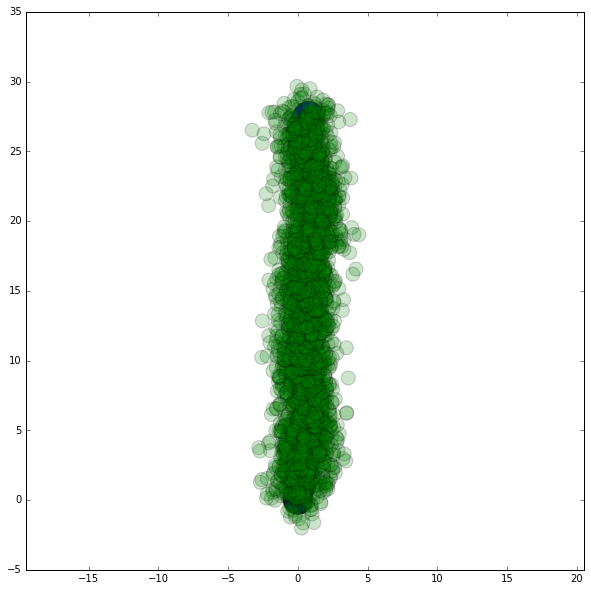

In [10]:
plotTrajectoryOverhead(Q, Z)

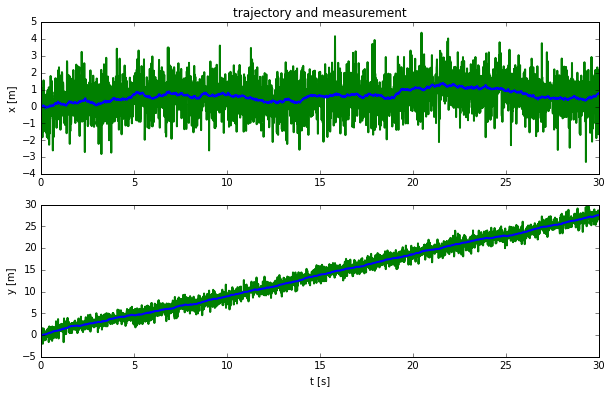

In [11]:
plotTrajectoryVsTime(t_hist, Q, Z)

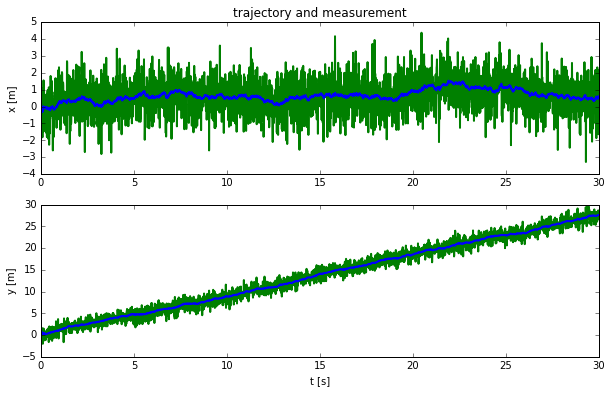

In [12]:
plotTrajectoryVsTime(t_hist, q_hat_hist, Z)